# Xây dựng và kiểm thử mô hình

## Nhập khẩu các thư viện

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score,recall_score, fbeta_score, make_scorer
import time

## Đọc tập dữ liệu thành DataFrame

In [2]:
DiabetesDataFrame = pd.read_csv("./diabetes.csv")

# Xử lý các giá trị bị thiếu

## Điền các giá trị bị trống bằng các giá trị ngẫu nhiên của từng biến

In [3]:
DiabetesDataFrame.loc[DiabetesDataFrame["Glucose"] == 0.0, "Glucose"] = np.NAN
DiabetesDataFrame.loc[DiabetesDataFrame["BloodPressure"] == 0.0, "BloodPressure"] = np.NAN
DiabetesDataFrame.loc[DiabetesDataFrame["SkinThickness"] == 0.0, "SkinThickness"] = np.NAN
DiabetesDataFrame.loc[DiabetesDataFrame["Insulin"] == 0.0, "Insulin"] = np.NAN
DiabetesDataFrame.loc[DiabetesDataFrame["BMI"] == 0.0, "BMI"] = np.NAN

ListOfAttributesContainMissingValues = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]

for attribute in ListOfAttributesContainMissingValues:
    number_missing = DiabetesDataFrame[attribute].isnull().sum()
    observed_values = DiabetesDataFrame.loc[DiabetesDataFrame[attribute].notnull(), attribute]
    np.random.seed(30)
    DiabetesDataFrame.loc[DiabetesDataFrame[attribute].isnull(), attribute] = np.random.choice(observed_values, 
                                                                                               number_missing, replace = True)


## Điền các giá trị bị trống bằng Stochastic Regression Imputation

In [4]:
missingPositionsAcrossAllAttributes = (DiabetesDataFrame.loc[:, ListOfAttributesContainMissingValues] == 0.0)

for attribute in ListOfAttributesContainMissingValues:
    X = DiabetesDataFrame.loc[:, DiabetesDataFrame.columns != attribute]
    y = DiabetesDataFrame[attribute]
    modelForImputation = LinearRegression()
    modelForImputation.fit(X, y)
    
    notMissingPositions = ~(missingPositionsAcrossAllAttributes[attribute])
    missingPositions = (missingPositionsAcrossAllAttributes[attribute])

    y_pred = modelForImputation.predict(X)
    
    np.random.seed(0)
    std = (DiabetesDataFrame.loc[notMissingPositions, attribute] - y_pred[notMissingPositions]).std()
    y_pred_with_random = np.random.normal(size = DiabetesDataFrame[attribute].shape[0],
              loc = y_pred,
              scale = std)
    dtype = DiabetesDataFrame[attribute].dtype

    DiabetesDataFrame.loc[(missingPositions) & 
                          (y_pred_with_random > 0), attribute] = y_pred[(missingPositions) & 
                                                                        (y_pred_with_random > 0)].astype(dtype)


## Số lượng và danh sách các giá trị ngoại lai của từng biến

In [5]:
numericAttributes = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", 
                     "Age"]
for attribute in numericAttributes:
    Q1 = DiabetesDataFrame[attribute].quantile(0.25)
    Q3 = DiabetesDataFrame[attribute].quantile(0.75)
    IQR = Q3 - Q1
    min_limit = Q1 - 1.5 * IQR
    max_limit = Q3 + 1.5 * IQR
    
    outlierPositions = (DiabetesDataFrame[attribute] < min_limit) | ((DiabetesDataFrame[attribute] > max_limit))
    count = DiabetesDataFrame.loc[outlierPositions, attribute].count()
    

    elements = ", ".join(DiabetesDataFrame.loc[outlierPositions, attribute].astype("str").array)
    print(f"{attribute} có {count} giá trị ngoại lai")
    if count != 0 :
        print(f"{elements}")
    else :
        print("Không có giá trị ngoại lai")
    print(f"{min_limit} < x < {max_limit}")
    print()

Pregnancies có 4 giá trị ngoại lai
15, 17, 14, 14
-6.5 < x < 13.5

Glucose có 0 giá trị ngoại lai
Không có giá trị ngoại lai
36.0 < x < 204.0

BloodPressure có 14 giá trị ngoại lai
30.0, 110.0, 108.0, 122.0, 30.0, 110.0, 108.0, 110.0, 24.0, 38.0, 106.0, 106.0, 106.0, 114.0
40.0 < x < 104.0

SkinThickness có 3 giá trị ngoại lai
60.0, 63.0, 99.0
-0.5 < x < 59.5

Insulin có 46 giá trị ngoại lai
543.0, 480.0, 846.0, 370.0, 440.0, 465.0, 495.0, 478.0, 485.0, 495.0, 478.0, 744.0, 370.0, 485.0, 680.0, 402.0, 402.0, 375.0, 370.0, 545.0, 846.0, 495.0, 600.0, 465.0, 415.0, 600.0, 579.0, 474.0, 510.0, 480.0, 495.0, 600.0, 370.0, 440.0, 540.0, 680.0, 540.0, 744.0, 480.0, 495.0, 387.0, 392.0, 370.0, 545.0, 510.0, 465.0
-98.5 < x < 369.5

BMI có 8 giá trị ngoại lai
53.2, 55.0, 67.1, 52.3, 52.3, 52.9, 59.4, 57.3
13.8125 < x < 50.3125

DiabetesPedigreeFunction có 29 giá trị ngoại lai
2.288, 1.441, 1.39, 1.893, 1.781, 1.222, 1.4, 1.321, 1.224, 2.329, 1.318, 1.213, 1.353, 1.224, 1.391, 1.476, 2.137, 1.7

## Kiểm tuổi của các đối tượng có giá trị ngoại lai ở thuộc tính Pregnancies

In [6]:
DiabetesDataFrame.loc[DiabetesDataFrame["Pregnancies"] >= 14, :] 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
88,15,136.0,70.0,32.0,110.0,37.1,0.153,43,1
159,17,163.0,72.0,41.0,114.0,40.9,0.817,47,1
298,14,100.0,78.0,25.0,184.0,36.6,0.412,46,1
455,14,175.0,62.0,30.0,110.0,33.6,0.212,38,1


## Kiểm sự trùng lặp dòng

In [7]:
numberOfDuplicates = DiabetesDataFrame.duplicated().sum()
print(f"Có {numberOfDuplicates} dòng trùng giá trị ")

Có 0 dòng trùng giá trị 


### Xem xét lỗi trùng các giá trị độc lập nhưng khác lớp

In [8]:
numberOfDulplicatesExceptOutcome = DiabetesDataFrame.loc[:, DiabetesDataFrame.columns != "Outcome"].duplicated().sum()
print(f"Số lượng dòng trùng giá trị biến độc lập {numberOfDulplicatesExceptOutcome}")

Số lượng dòng trùng giá trị biến độc lập 0


## Phân tích ma trận tương quan mũ hai

<AxesSubplot: title={'center': 'Correlation^2'}>

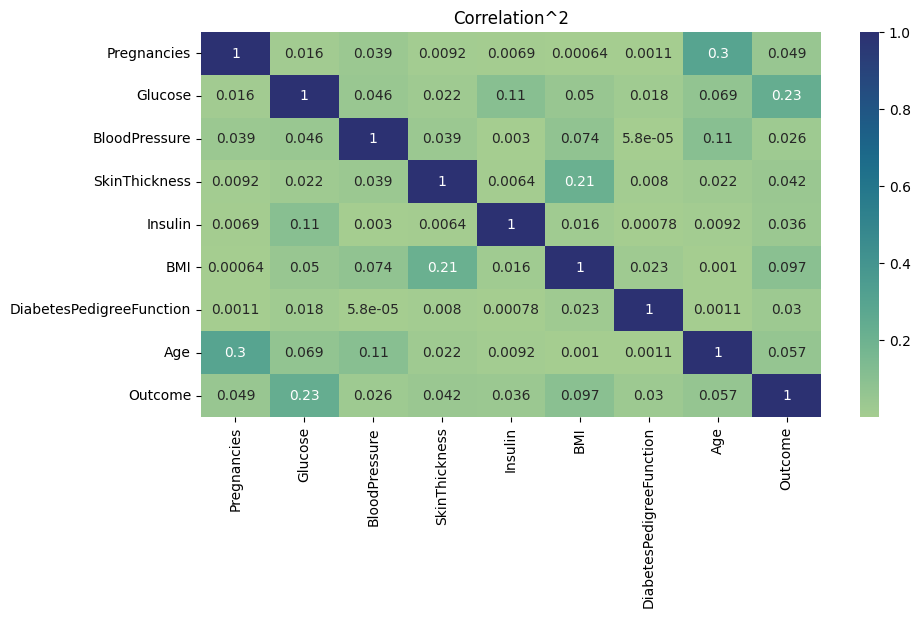

In [9]:
fig, axis = plt.subplots(nrows = 1, ncols = 1, figsize = (10,5))
data = DiabetesDataFrame.corr().map(lambda r : r * r)
axis.set_title("Correlation^2")
sn.heatmap(data = data, annot = True, ax = axis, cmap = "crest")

## Xây dựng mô hình

### Tạo ra training set và test set

In [10]:
InputAttributes = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", 
                   "DiabetesPedigreeFunction", "Age"]
OutputAttribute = "Outcome"
X = DiabetesDataFrame.loc[:,InputAttributes]
y = DiabetesDataFrame[OutputAttribute]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 42)

### Hàm xây dựng mô hình với tham số tốt nhất

In [11]:
def buildModelWithBestParameters(estimator, param_grid, scoring, refit, X_train, y_train):
    modelWithBestParameters = GridSearchCV(estimator = estimator,
                                          param_grid = param_grid,
                                           refit = refit)
    modelWithBestParameters.fit(X_train, y_train)
    return modelWithBestParameters

### Chọn tiêu chí đánh giá và tiêu chí đánh giá quan trọng nhất

In [12]:
accuracy_score = make_scorer(accuracy_score)
precisionScorer = make_scorer(precision_score, pos_label = 1)
recallScorer = make_scorer(recall_score, pos_label = 1)
F2Scorer = make_scorer(fbeta_score, beta = 2,pos_label = 1)

scoring = [recallScorer, F2Scorer]
refit = "recall"

### Xây dựng mô hình Logit

In [13]:
LogitParamGrid = {"solver" : ["lbfgs", "newton-cholesky", "sag", "saga", "newton-cg"],
                  "max_iter" : [1000,10000],
                  "class_weight" : [None, "balanced", {0 : (500/ 768), 1: (268/768)} ],
                  "penalty" : ["l2", None]
                 }
LogitModel = LogisticRegression()
LogitModelWithBestParameters = buildModelWithBestParameters(estimator = LogitModel, 
                                                        param_grid = LogitParamGrid, 
                                                        scoring = scoring, 
                                                        refit = refit,
                                                        X_train = X_train,
                                                        y_train = y_train)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

### Các tham số trong việc xây dựng mô hình Logit

In [14]:
print(LogitModelWithBestParameters.best_params_)

{'class_weight': None, 'max_iter': 1000, 'penalty': None, 'solver': 'lbfgs'}


### Hệ số của mô hình Logit

In [15]:
columns = LogitModelWithBestParameters.best_estimator_.feature_names_in_
index = "Logit Model"
coefficientsDataFrame = pd.DataFrame(index = [index] , columns = columns)

coefficients = LogitModelWithBestParameters.best_estimator_.coef_[0]
intercept = LogitModelWithBestParameters.best_estimator_.intercept_

coefficientsDataFrame.loc[index, :] = coefficients
coefficientsDataFrame.loc[index, "Intercept"] = intercept

coefficientsDataFrame

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Intercept
Logit Model,0.067796,0.033832,-0.013196,0.012102,-0.000021,0.095077,0.622442,0.03485,-9.165083


### Xây dựng mô hình K Nearest Neighbor

In [16]:
KNeighborParamGrid = {"n_neighbors" : [i for i in range(1,51)],
                      "weights" : ["uniform", "distance"],
                      "p" : [1,2,3,4,5]
                     }
KNeighborModel = KNeighborsClassifier()
KNeighborModelWithBestParameters = buildModelWithBestParameters(estimator = KNeighborModel, 
                                                        param_grid = KNeighborParamGrid, 
                                                        scoring = scoring, 
                                                        refit = refit,
                                                        X_train = X_train,
                                                        y_train = y_train)


### Các tham số trong việc xây dựng mô hình K Nearest Neighbor

In [17]:
print(KNeighborModelWithBestParameters.best_params_)

{'n_neighbors': 48, 'p': 1, 'weights': 'distance'}


## Đánh giá mô hình

### Hàm đánh giá mô hình

In [18]:
def returnMeasurements(model, X_test, y_test, modelName):
    y_pred = model.predict(X_test)

    accuracy = model.score(X_test, y_test) * 100
    precision = precision_score(y_true = y_test, y_pred = y_pred) * 100
    recall = recall_score(y_true = y_test, y_pred = y_pred) * 100
    f2 = fbeta_score(y_true = y_test, y_pred = y_pred, beta = 2) * 100
    
    data = {"Accuracy" : accuracy, 
    "Precision" : precision,
    "Recall" : recall,
    "f2" : f2,
    }
    
    measuresDataFrame = pd.DataFrame(data = data, index = [modelName])
    return measuresDataFrame

### Giá trị của các tiêu chí đánh giá của các mô hình

In [19]:
KNeighborModelMeasuresDataFrame = returnMeasurements(KNeighborModelWithBestParameters, X_test, y_test, "KNeighbor model")
LogitModelMeasuresDataFrame = returnMeasurements(LogitModelWithBestParameters, X_test, y_test, "Logit model")

MeasurementsDataFrame = pd.concat([LogitModelMeasuresDataFrame, KNeighborModelMeasuresDataFrame])
MeasurementsDataFrame

,Accuracy,Precision,Recall,f2
Logit model,74.675325,65.384615,61.818182,62.500000
KNeighbor model,77.922078,76.923077,54.545455,57.915058


### Biểu đồ thanh cho biết thông tin về các giá trị của các tiêu chí đánh giá của các mô hình

<AxesSubplot: ylabel='Phần trăm'>

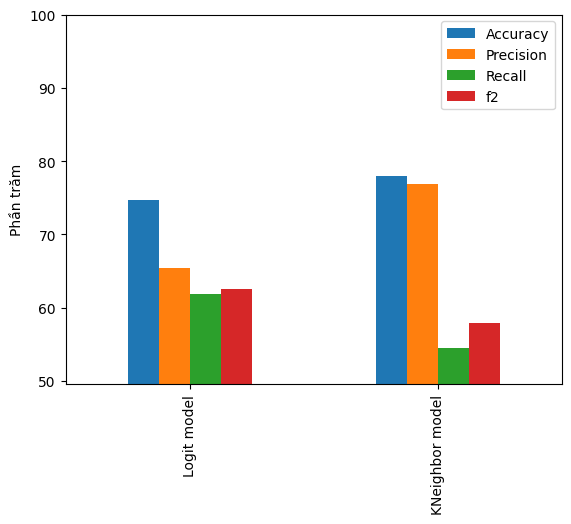

In [20]:
minValue = MeasurementsDataFrame.loc[:, ["Accuracy", "Precision", "Recall", "f2"]].min().min()
MeasurementsDataFrame.loc[:, ["Accuracy", "Precision", "Recall", "f2"]].plot.bar(ylim = (minValue - 5, 100), 
                                                                                 ylabel = "Phần trăm")

### Biểu đồ thanh cho biết thông tin về các thời gian tiên đoán của các mô hình

<BarContainer object of 2 artists>

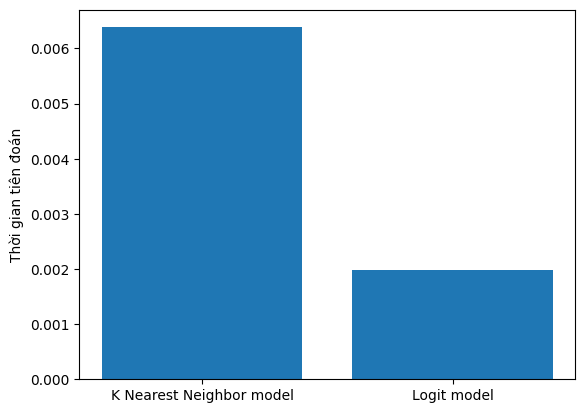

In [21]:
def averagePredictionTime(model, X, y):
    arr = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 42)
        t1 = time.time()
        model.predict(X_test)
        t2 = time.time()
        arr.append(t2 - t1)
    return pd.Series(arr).mean()

averagePredictionTimeForKNearestNeighbor = averagePredictionTime(KNeighborModelWithBestParameters, X, y)
averagePredictionTimeForLogisticRegression = averagePredictionTime(LogitModelWithBestParameters, X, y)

fig, axis = plt.subplots(nrows = 1, ncols = 1)
axis.set_ylabel("Thời gian tiên đoán")
axis.bar(["K Nearest Neighbor model", "Logit model"], [averagePredictionTimeForKNearestNeighbor, 
                                                        averagePredictionTimeForLogisticRegression])

### Hàm xóa dòng chứa giá trị ngoại lai

In [22]:
def removeOutliersInTrainingSet(X, y):
    for attribute in X.columns:
        Q1 = X[attribute].quantile(0.25)
        Q3 = X[attribute].quantile(0.75)
        IQR = Q3 - Q1
        
        Min = Q1 - 1.5 * IQR
        Max = Q3 + 1.5 * IQR
        
        outlierPositions = X[(X.loc[:, attribute] < Min) | (X.loc[:, attribute] > Max)].index
        
    return X.drop(outlierPositions), y.drop(outlierPositions)

## Loại trừ giá trị ngoại lai trong tập training set

In [23]:
X_train_without_outliers, y_train_without_outliers = removeOutliersInTrainingSet(X_train, y_train)

## Xây dựng mô hình

### Xây dựng mô hình logit

In [24]:
LogitParamGrid = {"solver" : ["lbfgs", "newton-cholesky", "sag", "saga", "newton-cg"],
                  "max_iter" : [1000,10000],
                  "class_weight" : [None, "balanced", {0 : (500/ 768), 1: (268/768)} ],
                  "penalty" : ["l2", None]
                 }
LogitModel = LogisticRegression()
LogitModelWithBestParameters = buildModelWithBestParameters(estimator = LogitModel, 
                                                        param_grid = LogitParamGrid, 
                                                        scoring = scoring, 
                                                        refit = refit,
                                                        X_train = X_train_without_outliers,
                                                        y_train = y_train_without_outliers)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

In [25]:
print(LogitModelWithBestParameters.best_params_)

{'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [26]:
print(LogitModelWithBestParameters.best_params_)

{'class_weight': None, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [27]:
columns = LogitModelWithBestParameters.best_estimator_.feature_names_in_
index = "Logit Model"
coefficientsDataFrame = pd.DataFrame(index = [index] , columns = columns)

coefficients = LogitModelWithBestParameters.best_estimator_.coef_[0]
intercept = LogitModelWithBestParameters.best_estimator_.intercept_

coefficientsDataFrame.loc[index, :] = coefficients
coefficientsDataFrame.loc[index, "Intercept"] = intercept

coefficientsDataFrame

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Intercept
Logit Model,0.03372,0.03502,-0.017812,0.010871,-0.000373,0.094697,0.576629,0.060561,-9.52323


### Xây dựng mô hình K Nearest Classifier

In [28]:
KNeighborParamGrid = {"n_neighbors" : [i for i in range(1,51)],
                      "weights" : ["uniform", "distance"],
                      "p" : [1,2]
                     }
KNeighborModel = KNeighborsClassifier()
KNeighborModelWithBestParameters = buildModelWithBestParameters(estimator = KNeighborModel, 
                                                        param_grid = KNeighborParamGrid, 
                                                        scoring = scoring, 
                                                        refit = refit,
                                                        X_train = X_train_without_outliers,
                                                        y_train = y_train_without_outliers)

### Các tham số trong việc xây dựng mô hình K Nearest Neighbor

In [29]:
print(KNeighborModelWithBestParameters.best_params_)

{'n_neighbors': 17, 'p': 2, 'weights': 'uniform'}


## Đánh giá mô hình

### Giá trị của các tiêu chí đánh giá của các mô hình

In [30]:
KNeighborModelMeasuresDataFrame = returnMeasurements(KNeighborModelWithBestParameters, X_test, y_test, "KNeighbor model")
LogitModelMeasuresDataFrame = returnMeasurements(LogitModelWithBestParameters, X_test, y_test, "Logit model")

MeasurementsDataFrame = pd.concat([LogitModelMeasuresDataFrame, KNeighborModelMeasuresDataFrame])
MeasurementsDataFrame

,Accuracy,Precision,Recall,f2
Logit model,70.129870,57.627119,61.818182,60.931900
KNeighbor model,76.623377,68.627451,63.636364,64.575646


### Biểu đồ thanh cho biết thông tin về các giá trị của các tiêu chí đánh giá của các mô hình

<AxesSubplot: ylabel='Phần trăm'>

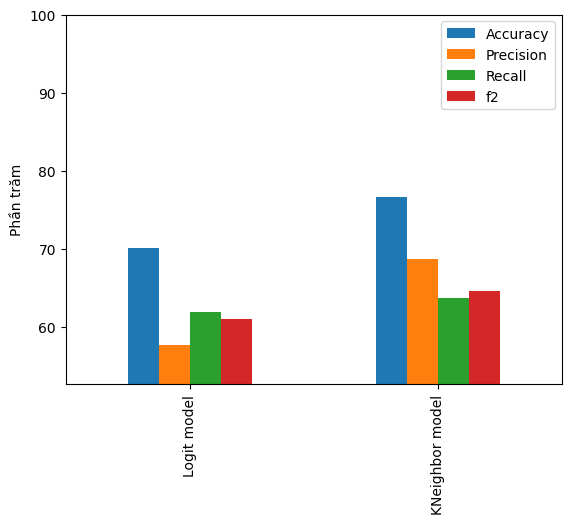

In [31]:
minValue = MeasurementsDataFrame.loc[:, ["Accuracy", "Precision", "Recall", "f2"]].min().min()
MeasurementsDataFrame.loc[:, ["Accuracy", "Precision", "Recall", "f2"]].plot.bar(ylim = (minValue - 5, 100), 
                                                                                 ylabel = "Phần trăm")

### Biểu đồ thanh cho biết thông tin về các thời gian tiên đoán của các mô hình

<BarContainer object of 2 artists>

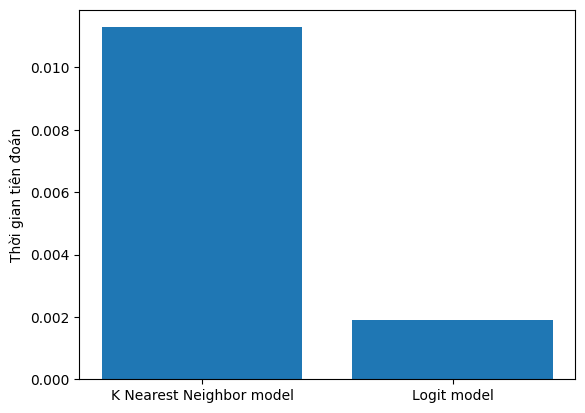

In [32]:
def averagePredictionTime(model, X, y):
    arr = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 42)
        t1 = time.time()
        model.predict(X_test)
        t2 = time.time()
        arr.append(t2 - t1)
    return pd.Series(arr).mean()

averagePredictionTimeForKNearestNeighbor = averagePredictionTime(KNeighborModelWithBestParameters, X, y)
averagePredictionTimeForLogisticRegression = averagePredictionTime(LogitModelWithBestParameters, X, y)

fig, axis = plt.subplots(nrows = 1, ncols = 1)
axis.set_ylabel("Thời gian tiên đoán")
axis.bar(["K Nearest Neighbor model", "Logit model"], [averagePredictionTimeForKNearestNeighbor, 
                                                        averagePredictionTimeForLogisticRegression])

## Làm cân bằng hai lớp trong training set

In [33]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = "auto", random_state = 42,k_neighbors = 10)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

## Xây dựng mô hình

### Xây dựng mô hình Logit

In [34]:
LogitParamGrid = {"solver" : ["lbfgs", "newton-cholesky", "sag", "saga", "newton-cg"],
                  "max_iter" : [1000,10000],
                  "class_weight" : [None, "balanced", {0 : (500/ 768), 1: (268/768)} ],
                  "penalty" : ["l2", None]
                 }
LogitModel = LogisticRegression()
LogitModelWithBestParameters = buildModelWithBestParameters(estimator = LogitModel, 
                                                        param_grid = LogitParamGrid, 
                                                        scoring = scoring, 
                                                        refit = refit,
                                                        X_train = X_train_balanced,
                                                        y_train = y_train_balanced)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

### Các tham số trong việc xây dựng mô hình Logit

In [35]:
print(LogitModelWithBestParameters.best_params_)

{'class_weight': 'balanced', 'max_iter': 1000, 'penalty': None, 'solver': 'lbfgs'}


### Hệ số và hệ số chặn

In [36]:
columns = LogitModelWithBestParameters.best_estimator_.feature_names_in_
index = "Logit Model"
coefficientsDataFrame = pd.DataFrame(index = [index] , columns = columns)

coefficients = LogitModelWithBestParameters.best_estimator_.coef_[0]
intercept = LogitModelWithBestParameters.best_estimator_.intercept_

coefficientsDataFrame.loc[index, :] = coefficients
coefficientsDataFrame.loc[index, "Intercept"] = intercept

coefficientsDataFrame

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Intercept
Logit Model,0.066578,0.037042,-0.015699,0.015527,-0.000079,0.095957,0.933535,0.036304,-9.067609


### Xây dựng mô hình K Nearest Neighbor

In [37]:
KNeighborParamGrid = {"n_neighbors" : [i for i in range(1,51)],
                      "weights" : ["uniform", "distance"],
                      "p" : [1,2]
                     }
KNeighborModel = KNeighborsClassifier()
KNeighborModelWithBestParameters = buildModelWithBestParameters(estimator = KNeighborModel, 
                                                        param_grid = KNeighborParamGrid, 
                                                        scoring = scoring, 
                                                        refit = refit,
                                                        X_train = X_train_balanced,
                                                        y_train = y_train_balanced)

### Các tham số trong việc xây dựng mô hình K Nearest Neighbor

In [38]:
print(KNeighborModelWithBestParameters.best_params_)

{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


## Đánh giá mô hình

### Giá trị của các tiêu chí đánh giá của các mô hình

In [39]:
KNeighborModelMeasuresDataFrame = returnMeasurements(KNeighborModelWithBestParameters, X_test, y_test, "KNeighbor model")
LogitModelMeasuresDataFrame = returnMeasurements(LogitModelWithBestParameters, X_test, y_test, "Logit model")

MeasurementsDataFrame = pd.concat([LogitModelMeasuresDataFrame, KNeighborModelMeasuresDataFrame])
MeasurementsDataFrame

,Accuracy,Precision,Recall,f2
Logit model,72.077922,58.571429,74.545455,70.689655
KNeighbor model,64.285714,50.000000,63.636364,60.344828


### Biểu đồ thanh cho biết thông tin về các giá trị của các tiêu chí đánh giá của các mô hình

<AxesSubplot: ylabel='Phần trăm'>

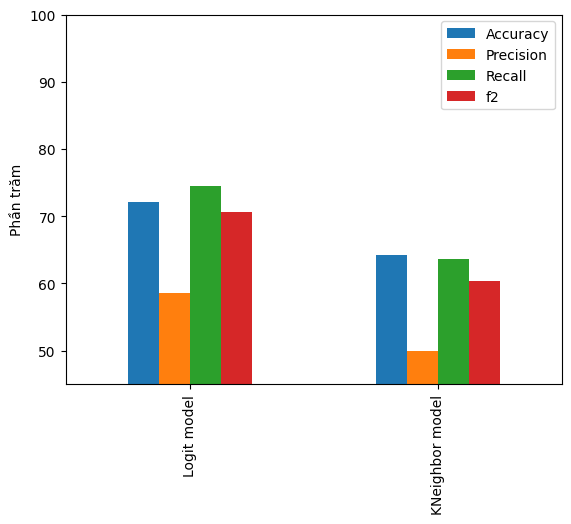

In [40]:
minValue = MeasurementsDataFrame.loc[:, ["Accuracy", "Precision", "Recall", "f2"]].min().min()
MeasurementsDataFrame.loc[:, ["Accuracy", "Precision", "Recall", "f2"]].plot.bar(ylim = (minValue - 5, 100), 
                                                                                 ylabel = "Phần trăm")

### Biểu đồ thanh cho biết thông tin về các thời gian tiên đoán của các mô hình

<BarContainer object of 2 artists>

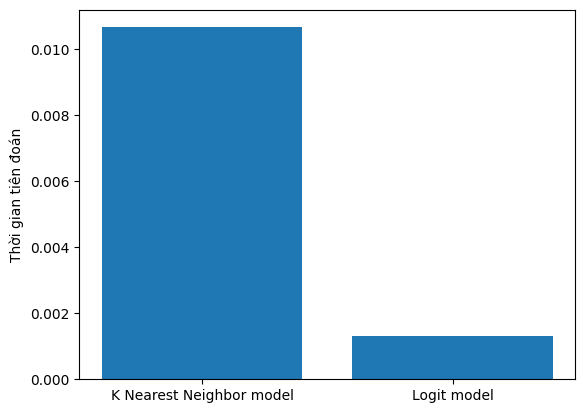

In [41]:
def averagePredictionTime(model, X, y):
    arr = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 42)
        t1 = time.time()
        model.predict(X_test)
        t2 = time.time()
        arr.append(t2 - t1)
    return pd.Series(arr).mean()

averagePredictionTimeForKNearestNeighbor = averagePredictionTime(KNeighborModelWithBestParameters, X, y)
averagePredictionTimeForLogisticRegression = averagePredictionTime(LogitModelWithBestParameters, X, y)

fig, axis = plt.subplots(nrows = 1, ncols = 1)
axis.set_ylabel("Thời gian tiên đoán")
axis.bar(["K Nearest Neighbor model", "Logit model"], [averagePredictionTimeForKNearestNeighbor, 
                                                        averagePredictionTimeForLogisticRegression])

## Loại trừ giá trị ngoại lai với số lượng lớp cân bằng

In [42]:
def removeOutliersInTrainingSet(X, y):
    for attribute in X.columns:
        Q1 = X[attribute].quantile(0.25)
        Q3 = X[attribute].quantile(0.75)
        IQR = Q3 - Q1
        
        Min = Q1 - 1.5 * IQR
        Max = Q3 + 1.5 * IQR
        
        outlierPositions = X[(X.loc[:, attribute] < Min) | (X.loc[:, attribute] > Max)].index
        
    return X.drop(outlierPositions), y.drop(outlierPositions)

In [44]:
X_train_with_balanced_class_without_outliers, y_train_with_balanced_class_without_outliers = removeOutliersInTrainingSet(
    X_train_balanced, y_train_balanced)

## Xây dựng mô hình

### Xây dựng mô hình logit

In [45]:
LogitParamGrid = {"solver" : ["lbfgs", "newton-cholesky", "sag", "saga", "newton-cg"],
                  "max_iter" : [1000,10000],
                  "class_weight" : [None, "balanced", {0 : (500/ 768), 1: (268/768)} ],
                  "penalty" : ["l2", None]
                 }
LogitModel = LogisticRegression()
LogitModelWithBestParameters = buildModelWithBestParameters(estimator = LogitModel, 
                                                        param_grid = LogitParamGrid, 
                                                        scoring = scoring, 
                                                        refit = refit,
                                                        X_train = X_train_with_balanced_class_without_outliers,
                                                        y_train = y_train_with_balanced_class_without_outliers)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the 

In [46]:
print(LogitModelWithBestParameters.best_params_)

{'class_weight': None, 'max_iter': 1000, 'penalty': None, 'solver': 'lbfgs'}


In [47]:
print(LogitModelWithBestParameters.best_params_)

{'class_weight': None, 'max_iter': 1000, 'penalty': None, 'solver': 'lbfgs'}


In [48]:
columns = LogitModelWithBestParameters.best_estimator_.feature_names_in_
index = "Logit Model"
coefficientsDataFrame = pd.DataFrame(index = [index] , columns = columns)

coefficients = LogitModelWithBestParameters.best_estimator_.coef_[0]
intercept = LogitModelWithBestParameters.best_estimator_.intercept_

coefficientsDataFrame.loc[index, :] = coefficients
coefficientsDataFrame.loc[index, "Intercept"] = intercept

coefficientsDataFrame

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Intercept
Logit Model,0.038652,0.037786,-0.018515,0.014457,-0.00033,0.094609,0.980243,0.059626,-9.481174


### Xây dựng mô hình K Nearest Classifier

In [49]:
KNeighborParamGrid = {"n_neighbors" : [i for i in range(1,51)],
                      "weights" : ["uniform", "distance"],
                      "p" : [1,2]
                     }
KNeighborModel = KNeighborsClassifier()
KNeighborModelWithBestParameters = buildModelWithBestParameters(estimator = KNeighborModel, 
                                                        param_grid = KNeighborParamGrid, 
                                                        scoring = scoring, 
                                                        refit = refit,
                                                        X_train = X_train_with_balanced_class_without_outliers,
                                                        y_train = y_train_with_balanced_class_without_outliers)

### Các tham số trong việc xây dựng mô hình K Nearest Neighbor

In [50]:
print(KNeighborModelWithBestParameters.best_params_)

{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}


## Đánh giá mô hình

### Giá trị của các tiêu chí đánh giá của các mô hình

In [51]:
KNeighborModelMeasuresDataFrame = returnMeasurements(KNeighborModelWithBestParameters, X_test, y_test, "KNeighbor model")
LogitModelMeasuresDataFrame = returnMeasurements(LogitModelWithBestParameters, X_test, y_test, "Logit model")

MeasurementsDataFrame = pd.concat([LogitModelMeasuresDataFrame, KNeighborModelMeasuresDataFrame])
MeasurementsDataFrame

,Accuracy,Precision,Recall,f2
Logit model,71.428571,57.746479,74.545455,70.446735
KNeighbor model,64.285714,50.000000,63.636364,60.344828


### Biểu đồ thanh cho biết thông tin về các giá trị của các tiêu chí đánh giá của các mô hình

<AxesSubplot: ylabel='Phần trăm'>

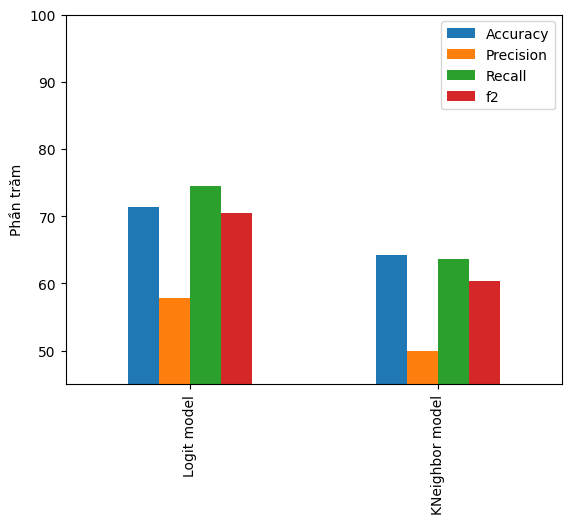

In [52]:
minValue = MeasurementsDataFrame.loc[:, ["Accuracy", "Precision", "Recall", "f2"]].min().min()
MeasurementsDataFrame.loc[:, ["Accuracy", "Precision", "Recall", "f2"]].plot.bar(ylim = (minValue - 5, 100), 
                                                                                 ylabel = "Phần trăm")

### Biểu đồ thanh cho biết thông tin về các thời gian tiên đoán của các mô hình

<BarContainer object of 2 artists>

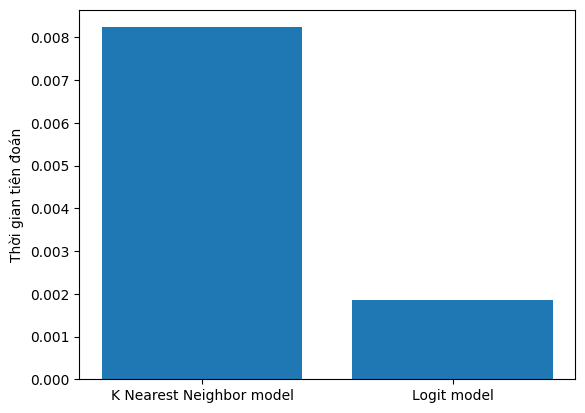

In [53]:
def averagePredictionTime(model, X, y):
    arr = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 42)
        t1 = time.time()
        model.predict(X_test)
        t2 = time.time()
        arr.append(t2 - t1)
    return pd.Series(arr).mean()

averagePredictionTimeForKNearestNeighbor = averagePredictionTime(KNeighborModelWithBestParameters, X, y)
averagePredictionTimeForLogisticRegression = averagePredictionTime(LogitModelWithBestParameters, X, y)

fig, axis = plt.subplots(nrows = 1, ncols = 1)
axis.set_ylabel("Thời gian tiên đoán")
axis.bar(["K Nearest Neighbor model", "Logit model"], [averagePredictionTimeForKNearestNeighbor, 
                                                        averagePredictionTimeForLogisticRegression])